# Worksheet 2 Part 2 - DDP for Two Heated Tanks

**Student:** Lucas de Oliveira Martim

# Setup and Common Definitions

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import bisect as bi

## Helper Functions for Grid Operations

In [71]:
def edInt(a, s, b):
    """Create evenly discretized interval from a to b with step s"""
    return np.linspace(a, b, int(np.floor((b-a)/s)) + 1)

def idx(aList, val):
    """Find nearest index in sorted list for given value"""
    i = bi.bisect(aList, val)  # right insertion point
    if i <= 0:  # val is before first element
        return 0
    elif i >= len(aList):  # val is after last element
        return len(aList) - 1
    elif val - aList[i-1] < aList[i] - val:  # closer to left
        return i - 1
    else:  # closer to right
        return i

def lookup(aList, vals):
    """Find nearest indices for values (nearest-neighbor interpolation)"""
    if isinstance(vals, (int, float, np.floating)):
        vals = [vals]
    return np.array([idx(aList, v) for v in vals], dtype=np.int32)

## System Parameters

Coupled tank dynamics:

$$\dot{T}_1 = -a_1 T_1 + b_1 T_2 + h_1 u_1$$
$$\dot{T}_2 = b_2 T_1 - a_2 T_2 + h_2 u_2$$

In [72]:
# System parameters
a1 = 0.01   # Heat loss coefficient tank 1
a2 = 0.01   # Heat loss coefficient tank 2
b1 = 0.005  # Coupling coefficient 2 to 1
b2 = 0.005  # Coupling coefficient 1 to 2
h1 = 2.0    # Heater gain tank 1
h2 = 2.0    # Heater gain tank 2

# Time horizon
t0 = 0
dt = 1      # Time step
tf = 100    # Final time
T_time = edInt(t0, dt, tf)
N = T_time.size

# Initial and reference states
x0 = np.array([0.0, 40.0])    # Initial temperatures [T1, T2]
x_ref = np.array([25.0, 30.0]) # Reference temperatures [T1, T2]

# Penalty for inadmissible states
infStValInc = 1e6
nullCtr = 0.0

# =============================================================================
# GLOBAL CONFIGURATION - Shared by all controllers
# =============================================================================
# Temperature limits (Celsius)
T_MIN = 0      # Minimum temperature for both tanks
T_MAX = 100    # Maximum temperature for both tanks

# Temperature discretization step
dT = 0.5         # Temperature step for both tanks [C]

# Control limits
U_MIN = 0      # Minimum control input (heater off)
U_MAX = 1      # Maximum control input (heater full)

# Control discretization step
dU = 1         # Control step

# Cost weights (used consistently across all controllers)
Q1_COST = 10.0  # State cost weight for Tank 1
Q2_COST = 10.0  # State cost weight for Tank 2
R1_COST = 1.0   # Control cost weight for Heater 1
R2_COST = 1.0   # Control cost weight for Heater 2
# =============================================================================

# (a): DDP with Value Iteration for Coupled System

## Configuration

In [73]:
# State space discretization - using GLOBAL CONFIG
dT1_a = dT   # Temperature step for tank 1
dT2_a = dT    # Temperature step for tank 2
T1_min_a, T1_max_a = T_MIN, T_MAX    # Tank 1 temperature range [Celsius]
T2_min_a, T2_max_a = T_MIN, T_MAX   # Tank 2 temperature range [Celsius]

# Control space discretization - using GLOBAL CONFIG
du1_a = dU   # Control step for heater 1
du2_a = dU   # Control step for heater 2
u1_min_a, u1_max_a = U_MIN, U_MAX     # Control range for heater 1
u2_min_a, u2_max_a = U_MIN, U_MAX     # Control range for heater 2

# Create admissible sets
T1_grid_a = edInt(T1_min_a, dT1_a, T1_max_a)
T2_grid_a = edInt(T2_min_a, dT2_a, T2_max_a)
U1_a = edInt(u1_min_a, du1_a, u1_max_a)
U2_a = edInt(u2_min_a, du2_a, u2_max_a)

# Create state space meshgrid
T1_mesh_a, T2_mesh_a = np.meshgrid(T1_grid_a, T2_grid_a)

# Cost weights - using GLOBAL CONFIG
Q1_a = Q1_COST    # State cost weight for tank 1
Q2_a = Q2_COST    # State cost weight for tank 2
R1_a = R1_COST     # Control cost weight for heater 1
R2_a = R2_COST     # Control cost weight for heater 2

print(f"  State space: {T1_grid_a.size}  {T2_grid_a.size} = {T1_grid_a.size * T2_grid_a.size} states")
print(f"  Control space: {U1_a.size}  {U2_a.size} = {U1_a.size * U2_a.size} controls")
print(f"  Time steps: {N}")

  State space: 201  201 = 40401 states
  Control space: 2  2 = 4 controls
  Time steps: 101


## Initialize Value Function and Optimal Control

In [74]:
# Initialize value function and optimal control arrays
V_a = np.zeros((T2_grid_a.size, T1_grid_a.size, N))
u1_opt_a = np.zeros_like(V_a)
u2_opt_a = np.zeros_like(V_a)

# Terminal cost (only state error, no control)
V_a[:, :, N-1] = Q1_a * (T1_mesh_a - x_ref[0])**2 + Q2_a * (T2_mesh_a - x_ref[1])**2

## Backward Pass (Value Iteration)

Bellman equation:
$$V(x, k) = \min_{u_1, u_2} \left[ L(x, u) + V(f(x, u), k+1) \right]$$

where:
- $L(x, u) = Q_1(T_1 - T_1^{ref})^2 + Q_2(T_2 - T_2^{ref})^2 + R_1 u_1^2 + R_2 u_2^2$
- $f(x,u)$ is the next state given by the system dynamics

In [75]:

depth = 0
inadmissible_count_a = 0

for k in range(N-2, depth-1, -1):  # Go backwards from N-2 to 0
    if k % 20 == 0:
        print(f"  Processing time step {k}/{N-1}...")
    
    for i in range(T2_grid_a.size):
        for j in range(T1_grid_a.size):
            # Current state
            T1_curr = T1_grid_a[j]
            T2_curr = T2_grid_a[i]
            
            # Initialize minimum cost
            min_cost = float('inf')
            best_u1 = nullCtr
            best_u2 = nullCtr
            
            # Try all control combinations
            for u1_val in U1_a:
                for u2_val in U2_a:
                    # Instant cost
                    L = Q1_a * (T1_curr - x_ref[0])**2 + Q2_a * (T2_curr - x_ref[1])**2 + \
                        R1_a * u1_val**2 + R2_a * u2_val**2
                    
                    # Predict next state using coupled dynamics
                    T1_next = T1_curr + (-a1 * T1_curr + b1 * T2_curr + h1 * u1_val) * dt
                    T2_next = T2_curr + (b2 * T1_curr - a2 * T2_curr + h2 * u2_val) * dt
                    
                    # Check if next state is admissible
                    if (T1_next >= T1_min_a and T1_next <= T1_max_a and 
                        T2_next >= T2_min_a and T2_next <= T2_max_a):
                        
                        # Find nearest grid indices
                        j_next = lookup(T1_grid_a, T1_next)[0]
                        i_next = lookup(T2_grid_a, T2_next)[0]
                        
                        # Bellman equation: total cost = instant cost + future cost
                        total_cost = L + V_a[i_next, j_next, k+1]
                        
                        # Update if this is better
                        if total_cost < min_cost:
                            min_cost = total_cost
                            best_u1 = u1_val
                            best_u2 = u2_val
            
            # Store optimal cost and control
            if min_cost == float('inf'):
                # No admissible control found - penalize
                V_a[i, j, k] = V_a[i, j, k+1] + infStValInc
                inadmissible_count_a += 1
            else:
                V_a[i, j, k] = min_cost
            
            u1_opt_a[i, j, k] = best_u1
            u2_opt_a[i, j, k] = best_u2

print(f"  Inadmissible states encountered: {inadmissible_count_a}")

  Processing time step 80/100...
  Processing time step 60/100...
  Processing time step 40/100...
  Processing time step 20/100...
  Processing time step 0/100...
  Inadmissible states encountered: 0


## Part (a) - Forward Simulation

In [76]:
# Simulate from initial state
x_a = np.zeros((N, 2))
x_a[0, :] = x0
u1_sim_a = np.zeros(N)
u2_sim_a = np.zeros(N)


for k in range(N-1):
    # Check if current state is admissible
    if not (x_a[k, 0] >= T1_min_a and x_a[k, 0] <= T1_max_a and
            x_a[k, 1] >= T2_min_a and x_a[k, 1] <= T2_max_a):
        print(f"Warning: Stopped at k={k}/{N}: state [{x_a[k,0]:.2f}, {x_a[k,1]:.2f}] out of bounds")
        x_a = x_a[:k+1, :]
        u1_sim_a = u1_sim_a[:k+1]
        u2_sim_a = u2_sim_a[:k+1]
        break
    
    # Find nearest grid indices
    j_T1 = lookup(T1_grid_a, x_a[k, 0])[0]
    i_T2 = lookup(T2_grid_a, x_a[k, 1])[0]
    
    # Get optimal control
    u1_sim_a[k] = u1_opt_a[i_T2, j_T1, k]
    u2_sim_a[k] = u2_opt_a[i_T2, j_T1, k]
    
    # Propagate dynamics
    x_a[k+1, 0] = x_a[k, 0] + (-a1 * x_a[k, 0] + b1 * x_a[k, 1] + h1 * u1_sim_a[k]) * dt
    x_a[k+1, 1] = x_a[k, 1] + (b2 * x_a[k, 0] - a2 * x_a[k, 1] + h2 * u2_sim_a[k]) * dt

print(f"  Final state: T1={x_a[-1,0]:.2f}C, T2={x_a[-1,1]:.2f}C")
print(f"  Reference:   T1={x_ref[0]}C, T2={x_ref[1]}C")
print(f"  Final error: T1={x_a[-1,0]-x_ref[0]:.2f}C, T2={x_a[-1,1]-x_ref[1]:.2f}C")

  Final state: T1=25.55C, T2=29.59C
  Reference:   T1=25.0C, T2=30.0C
  Final error: T1=0.55C, T2=-0.41C


## Performance Metrics

In [77]:
# Calculate performance metrics
ss_error_T1_a = x_a[-1, 0] - x_ref[0]
ss_error_T2_a = x_a[-1, 1] - x_ref[1]

# Calculate total cost
total_cost_a = 0
for k in range(len(x_a)-1):
    L_k = Q1_a * (x_a[k, 0] - x_ref[0])**2 + Q2_a * (x_a[k, 1] - x_ref[1])**2 + \
          R1_a * u1_sim_a[k]**2 + R2_a * u2_sim_a[k]**2
    total_cost_a += L_k * dt

# Terminal cost
L_N = Q1_a * (x_a[-1, 0] - x_ref[0])**2 + Q2_a * (x_a[-1, 1] - x_ref[1])**2
total_cost_a += L_N

# Get optimal value at x0
j_x0 = lookup(T1_grid_a, x0[0])[0]
i_x0 = lookup(T2_grid_a, x0[1])[0]
V_x0_a = V_a[i_x0, j_x0, 0]

print("\n" + "="*60)
print("="*60)
print(f"Steady-state error Tank 1: {ss_error_T1_a:.4f} C")
print(f"Steady-state error Tank 2: {ss_error_T2_a:.4f} C")
print(f"Total accumulated cost:    {total_cost_a:.2f}")
print(f"Optimal value at x0:       {V_x0_a:.2f}")
print(f"\nAverage control effort:")
print(f"  u1: {np.mean(u1_sim_a):.4f} (max: {np.max(u1_sim_a):.4f})")
print(f"  u2: {np.mean(u2_sim_a):.4f} (max: {np.max(u2_sim_a):.4f})")
print("="*60)


Steady-state error Tank 1: 0.5467 C
Steady-state error Tank 2: -0.4090 C
Total accumulated cost:    46351.21
Optimal value at x0:       48919.50

Average control effort:
  u1: 0.1584 (max: 1.0000)
  u2: 0.0495 (max: 1.0000)


## Visualization

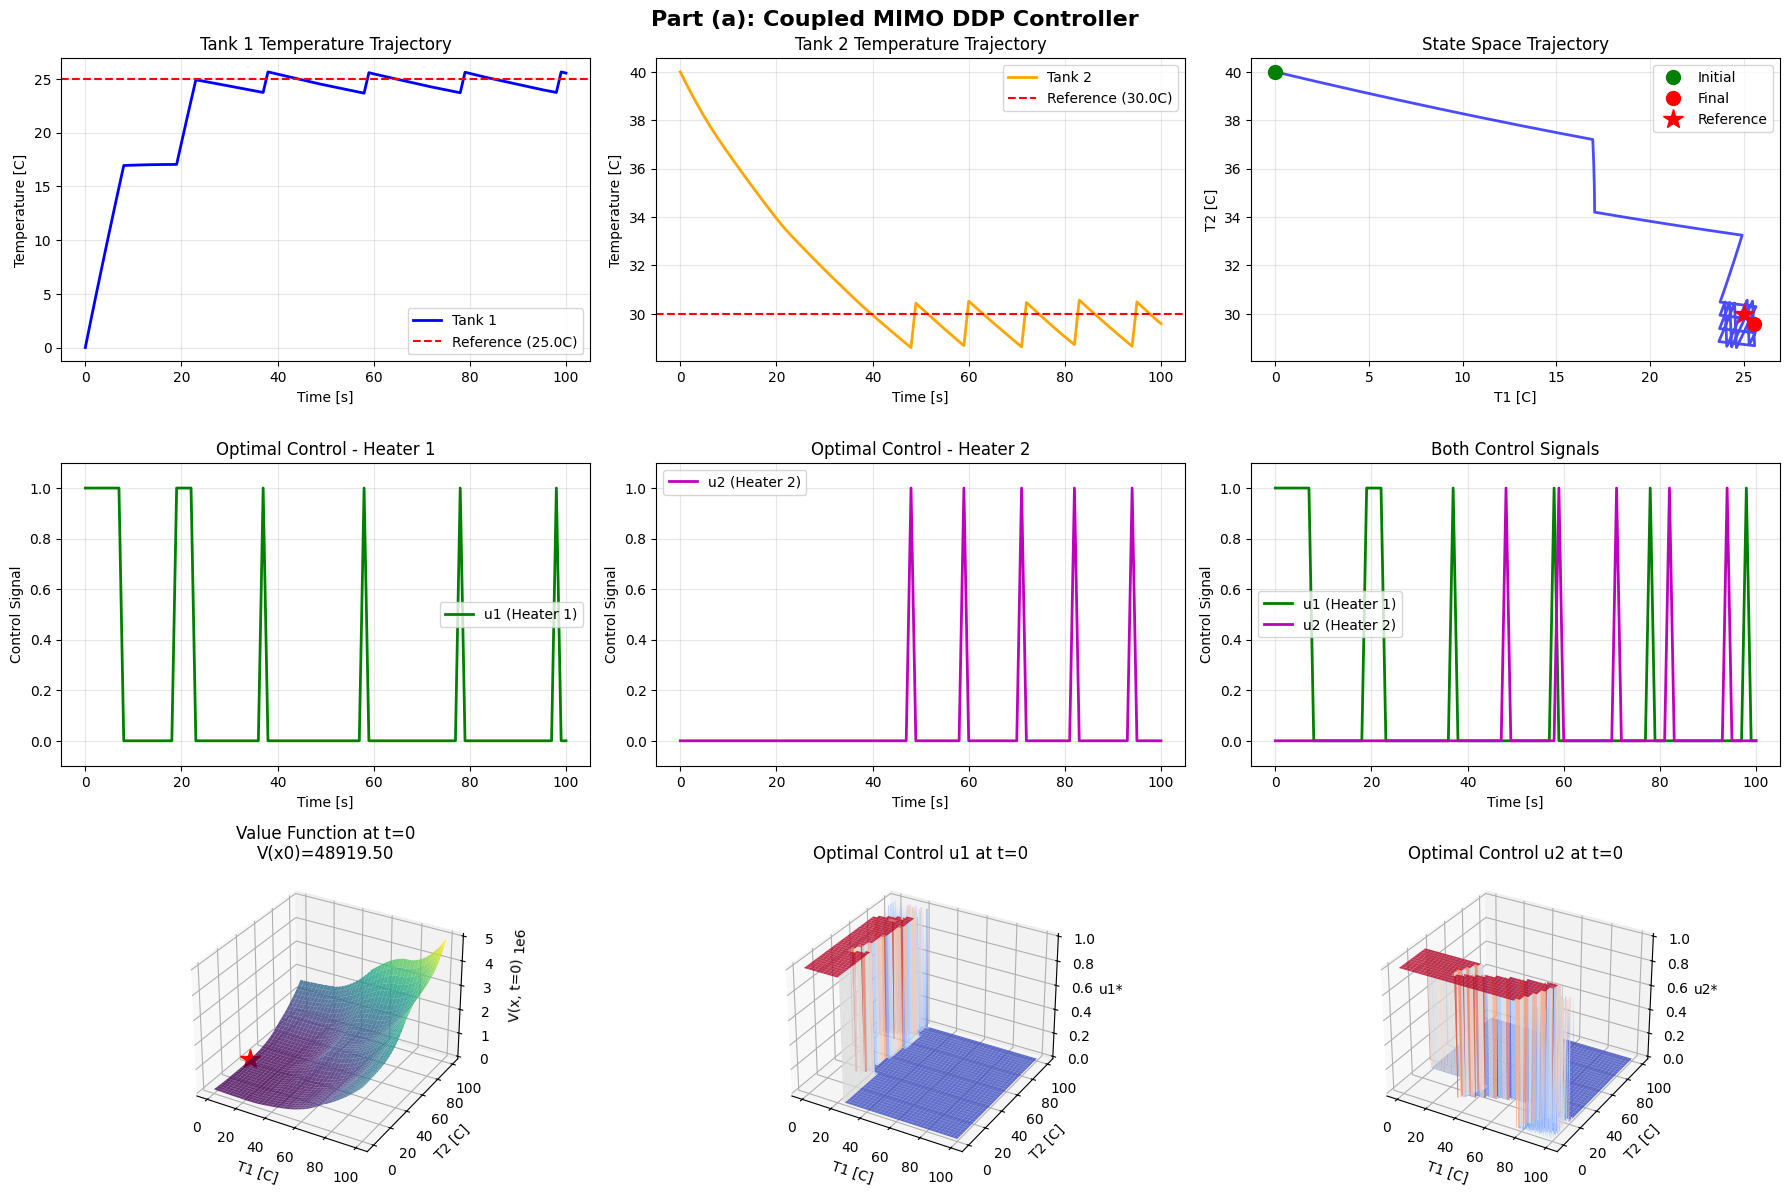

In [78]:
# Create comprehensive visualization for Part (a)
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Part (a): Coupled MIMO DDP Controller', fontsize=16, fontweight='bold')

# State trajectories
ax1 = plt.subplot(3, 3, 1)
ax1.plot(T_time[:len(x_a)], x_a[:, 0], 'b-', linewidth=2, label='Tank 1')
ax1.axhline(y=x_ref[0], color='red', linestyle='--', label=f'Reference ({x_ref[0]}C)')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [C]')
ax1.set_title('Tank 1 Temperature Trajectory')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 2)
ax2.plot(T_time[:len(x_a)], x_a[:, 1], 'orange', linewidth=2, label='Tank 2')
ax2.axhline(y=x_ref[1], color='red', linestyle='--', label=f'Reference ({x_ref[1]}C)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Temperature [C]')
ax2.set_title('Tank 2 Temperature Trajectory')
ax2.legend()
ax2.grid(True, alpha=0.3)

# State space trajectory
ax3 = plt.subplot(3, 3, 3)
ax3.plot(x_a[:, 0], x_a[:, 1], 'b-', linewidth=2, alpha=0.7)
ax3.plot(x_a[0, 0], x_a[0, 1], 'go', markersize=10, label='Initial')
ax3.plot(x_a[-1, 0], x_a[-1, 1], 'ro', markersize=10, label='Final')
ax3.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference')
ax3.set_xlabel('T1 [C]')
ax3.set_ylabel('T2 [C]')
ax3.set_title('State Space Trajectory')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Control signals
ax4 = plt.subplot(3, 3, 4)
ax4.plot(T_time[:len(u1_sim_a)], u1_sim_a, 'g-', linewidth=2, label='u1 (Heater 1)')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Control Signal')
ax4.set_title('Optimal Control - Heater 1')
ax4.set_ylim([-0.1, 1.1])
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
ax5.plot(T_time[:len(u2_sim_a)], u2_sim_a, 'm-', linewidth=2, label='u2 (Heater 2)')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Control Signal')
ax5.set_title('Optimal Control - Heater 2')
ax5.set_ylim([-0.1, 1.1])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Both controls together
ax6 = plt.subplot(3, 3, 6)
ax6.plot(T_time[:len(u1_sim_a)], u1_sim_a, 'g-', linewidth=2, label='u1 (Heater 1)')
ax6.plot(T_time[:len(u2_sim_a)], u2_sim_a, 'm-', linewidth=2, label='u2 (Heater 2)')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Control Signal')
ax6.set_title('Both Control Signals')
ax6.set_ylim([-0.1, 1.1])
ax6.legend()
ax6.grid(True, alpha=0.3)

# Value function at t=0
ax7 = plt.subplot(3, 3, 7, projection='3d')
ax7.plot_surface(T1_mesh_a, T2_mesh_a, V_a[:, :, 0], cmap='viridis', alpha=0.8)
ax7.plot([x0[0]], [x0[1]], [V_x0_a], 'r*', markersize=15)
ax7.set_xlabel('T1 [C]')
ax7.set_ylabel('T2 [C]')
ax7.set_zlabel('V(x, t=0)')
ax7.set_title(f'Value Function at t=0\nV(x0)={V_x0_a:.2f}')

# Optimal control policy u1 at t=0
ax8 = plt.subplot(3, 3, 8, projection='3d')
ax8.plot_surface(T1_mesh_a, T2_mesh_a, u1_opt_a[:, :, 0], cmap='coolwarm', alpha=0.8)
ax8.set_xlabel('T1 [C]')
ax8.set_ylabel('T2 [C]')
ax8.set_zlabel('u1*')
ax8.set_title('Optimal Control u1 at t=0')

# Optimal control policy u2 at t=0
ax9 = plt.subplot(3, 3, 9, projection='3d')
ax9.plot_surface(T1_mesh_a, T2_mesh_a, u2_opt_a[:, :, 0], cmap='coolwarm', alpha=0.8)
ax9.set_xlabel('T1 [C]')
ax9.set_ylabel('T2 [C]')
ax9.set_zlabel('u2*')
ax9.set_title('Optimal Control u2 at t=0')

plt.tight_layout()
plt.show()

# Part (b): SISO Controllers (Single-Input/Single-Output)

Compute **two separate SISO-DDP controllers** working exclusively and independently on their tanks:

1. **Controller 1**: Controls only Tank 1 (u1), treating Tank 2 temperature as a disturbance
2. **Controller 2**: Controls only Tank 2 (u2), treating Tank 1 temperature as a disturbance

## Configuration for SISO Controllers

In [79]:
# SISO Controller 1 (Tank 1): State space includes both T1 and T2, but only u1 is controlled
# Using GLOBAL CONFIG
dT1_b1 = dT    # Temperature step for tank 1
dT2_b1 = dT    # Temperature step for tank 2 (disturbance)
T1_min_b1, T1_max_b1 = T_MIN, T_MAX
T2_min_b1, T2_max_b1 = T_MIN, T_MAX
du1_b1 = dU   # Control step for heater 1
u1_min_b1, u1_max_b1 = U_MIN, U_MAX

# Create grids for Controller 1
T1_grid_b1 = edInt(T1_min_b1, dT1_b1, T1_max_b1)
T2_grid_b1 = edInt(T2_min_b1, dT2_b1, T2_max_b1)
U1_b1 = edInt(u1_min_b1, du1_b1, u1_max_b1)
T1_mesh_b1, T2_mesh_b1 = np.meshgrid(T1_grid_b1, T2_grid_b1)

# SISO Controller 2 (Tank 2): State space includes both T1 and T2, but only u2 is controlled
# Using GLOBAL CONFIG
dT1_b2 = dT    # Temperature step for tank 1 (disturbance)
dT2_b2 = dT    # Temperature step for tank 2
T1_min_b2, T1_max_b2 = T_MIN, T_MAX
T2_min_b2, T2_max_b2 = T_MIN, T_MAX
du2_b2 = dU   # Control step for heater 2
u2_min_b2, u2_max_b2 = U_MIN, U_MAX

# Create grids for Controller 2
T1_grid_b2 = edInt(T1_min_b2, dT1_b2, T1_max_b2)
T2_grid_b2 = edInt(T2_min_b2, dT2_b2, T2_max_b2)
U2_b2 = edInt(u2_min_b2, du2_b2, u2_max_b2)
T1_mesh_b2, T2_mesh_b2 = np.meshgrid(T1_grid_b2, T2_grid_b2)

# Cost weights for SISO controllers - using GLOBAL CONFIG
Q1_b1 = Q1_COST   # State cost for Tank 1 in Controller 1
Q2_b1 = 0.0    # No direct cost for Tank 2 in Controller 1 (it's a disturbance)
R1_b1 = R1_COST    # Control cost for u1

Q1_b2 = 0.0    # No direct cost for Tank 1 in Controller 2 (it's a disturbance)
Q2_b2 = Q2_COST   # State cost for Tank 2 in Controller 2
R2_b2 = R2_COST    # Control cost for u2

print(f"  SISO Controller 1 (Tank 1):")
print(f"    State space: {T1_grid_b1.size}  {T2_grid_b1.size} = {T1_grid_b1.size * T2_grid_b1.size} states")
print(f"    Control space: {U1_b1.size} controls (u1 only)")
print(f"  SISO Controller 2 (Tank 2):")
print(f"    State space: {T1_grid_b2.size}  {T2_grid_b2.size} = {T1_grid_b2.size * T2_grid_b2.size} states")
print(f"    Control space: {U2_b2.size} controls (u2 only)")

  SISO Controller 1 (Tank 1):
    State space: 201  201 = 40401 states
    Control space: 2 controls (u1 only)
  SISO Controller 2 (Tank 2):
    State space: 201  201 = 40401 states
    Control space: 2 controls (u2 only)


## SISO Controller 1: Tank 1 Only (u1)

This controller focuses on regulating Tank 1 to its reference temperature.
Tank 2 temperature is treated as a time-varying disturbance.

Dynamics: $\dot{T}_1 = -a_1 T_1 + b_1 T_2 + h_1 u_1$

Control: $u_1 \in [0, 1]$, $u_2 = 0$ (fixed)

In [80]:
# Initialize for Controller 1
V_b1 = np.zeros((T2_grid_b1.size, T1_grid_b1.size, N))
u1_opt_b1 = np.zeros_like(V_b1)

# Terminal cost (only Tank 1 error matters)
V_b1[:, :, N-1] = Q1_b1 * (T1_mesh_b1 - x_ref[0])**2 + Q2_b1 * (T2_mesh_b1 - x_ref[1])**2

In [81]:

inadmissible_count_b1 = 0

for k in range(N-2, -1, -1):
    if k % 20 == 0:
        print(f"  Processing time step {k}/{N-1}...")
    
    for i in range(T2_grid_b1.size):
        for j in range(T1_grid_b1.size):
            T1_curr = T1_grid_b1[j]
            T2_curr = T2_grid_b1[i]
            
            min_cost = float('inf')
            best_u1 = nullCtr
            
            # Only optimize over u1 (u2 = 0 fixed)
            for u1_val in U1_b1:
                u2_val = 0.0  # Controller 1 doesn't control Tank 2
                
                # Instant cost (only Tank 1 error)
                L = Q1_b1 * (T1_curr - x_ref[0])**2 + R1_b1 * u1_val**2
                
                # Predict next state
                T1_next = T1_curr + (-a1 * T1_curr + b1 * T2_curr + h1 * u1_val) * dt
                T2_next = T2_curr + (b2 * T1_curr - a2 * T2_curr + h2 * u2_val) * dt
                
                # Check admissibility
                if (T1_next >= T1_min_b1 and T1_next <= T1_max_b1 and 
                    T2_next >= T2_min_b1 and T2_next <= T2_max_b1):
                    
                    j_next = lookup(T1_grid_b1, T1_next)[0]
                    i_next = lookup(T2_grid_b1, T2_next)[0]
                    
                    total_cost = L + V_b1[i_next, j_next, k+1]
                    
                    if total_cost < min_cost:
                        min_cost = total_cost
                        best_u1 = u1_val
            
            if min_cost == float('inf'):
                V_b1[i, j, k] = V_b1[i, j, k+1] + infStValInc
                inadmissible_count_b1 += 1
            else:
                V_b1[i, j, k] = min_cost
            
            u1_opt_b1[i, j, k] = best_u1

print(f"  Inadmissible states encountered: {inadmissible_count_b1}")

  Processing time step 80/100...
  Processing time step 60/100...
  Processing time step 40/100...
  Processing time step 20/100...
  Processing time step 0/100...
  Inadmissible states encountered: 0


## SISO Controller 2: Tank 2 Only (u2)

This controller focuses on regulating Tank 2 to its reference temperature.
Tank 1 temperature is treated as a time-varying disturbance.

Dynamics: $\dot{T}_2 = b_2 T_1 - a_2 T_2 + h_2 u_2$

Control: $u_2 \in [0, 1]$, $u_1 = 0$ (fixed)

In [82]:
# Initialize for Controller 2
V_b2 = np.zeros((T2_grid_b2.size, T1_grid_b2.size, N))
u2_opt_b2 = np.zeros_like(V_b2)

# Terminal cost (only Tank 2 error matters)
V_b2[:, :, N-1] = Q1_b2 * (T1_mesh_b2 - x_ref[0])**2 + Q2_b2 * (T2_mesh_b2 - x_ref[1])**2

In [83]:
print("SISO Controller 2 - Backward pass...")

inadmissible_count_b2 = 0

for k in range(N-2, -1, -1):
    if k % 20 == 0:
        print(f"Processing time step {k}/{N-1}...")
    
    for i in range(T2_grid_b2.size):
        for j in range(T1_grid_b2.size):
            T1_curr = T1_grid_b2[j]
            T2_curr = T2_grid_b2[i]
            
            min_cost = float('inf')
            best_u2 = nullCtr
            
            # Only optimize over u2 (u1 = 0 fixed)
            for u2_val in U2_b2:
                u1_val = 0.0  # Controller 2 doesn't control Tank 1
                
                # Instant cost (only Tank 2 error)
                L = Q2_b2 * (T2_curr - x_ref[1])**2 + R2_b2 * u2_val**2
                
                # Predict next state
                T1_next = T1_curr + (-a1 * T1_curr + b1 * T2_curr + h1 * u1_val) * dt
                T2_next = T2_curr + (b2 * T1_curr - a2 * T2_curr + h2 * u2_val) * dt
                
                # Check admissibility
                if (T1_next >= T1_min_b2 and T1_next <= T1_max_b2 and 
                    T2_next >= T2_min_b2 and T2_next <= T2_max_b2):
                    
                    j_next = lookup(T1_grid_b2, T1_next)[0]
                    i_next = lookup(T2_grid_b2, T2_next)[0]
                    
                    total_cost = L + V_b2[i_next, j_next, k+1]
                    
                    if total_cost < min_cost:
                        min_cost = total_cost
                        best_u2 = u2_val
            
            if min_cost == float('inf'):
                V_b2[i, j, k] = V_b2[i, j, k+1] + infStValInc
                inadmissible_count_b2 += 1
            else:
                V_b2[i, j, k] = min_cost
            
            u2_opt_b2[i, j, k] = best_u2

print(f"SISO Controller 2 backward pass complete!")
print(f"Inadmissible states encountered: {inadmissible_count_b2}")

SISO Controller 2 - Backward pass...
Processing time step 80/100...
Processing time step 60/100...
Processing time step 40/100...
Processing time step 20/100...
Processing time step 0/100...
SISO Controller 2 backward pass complete!
Inadmissible states encountered: 0


## Test SISO Controllers Individually

Test each controller separately to understand their individual behavior.

In [84]:
# Test Controller 1 only (u1, controlling Tank 1)
x_b1_only = np.zeros((N, 2))
x_b1_only[0, :] = x0
u1_sim_b1_only = np.zeros(N)

print("Testing SISO Controller 1 only (Tank 1):")

for k in range(N-1):
    if not (x_b1_only[k, 0] >= T1_min_b1 and x_b1_only[k, 0] <= T1_max_b1 and
            x_b1_only[k, 1] >= T2_min_b1 and x_b1_only[k, 1] <= T2_max_b1):
        print(f"Warning: Out of bounds at k={k}")
        x_b1_only = x_b1_only[:k+1, :]
        u1_sim_b1_only = u1_sim_b1_only[:k+1]
        break
    
    j_T1 = lookup(T1_grid_b1, x_b1_only[k, 0])[0]
    i_T2 = lookup(T2_grid_b1, x_b1_only[k, 1])[0]
    
    u1_sim_b1_only[k] = u1_opt_b1[i_T2, j_T1, k]
    
    x_b1_only[k+1, 0] = x_b1_only[k, 0] + (-a1 * x_b1_only[k, 0] + b1 * x_b1_only[k, 1] + h1 * u1_sim_b1_only[k]) * dt
    x_b1_only[k+1, 1] = x_b1_only[k, 1] + (b2 * x_b1_only[k, 0] - a2 * x_b1_only[k, 1]) * dt  # u2 = 0

print(f"Final: T1={x_b1_only[-1,0]:.2f}C, T2={x_b1_only[-1,1]:.2f}C")
print(f"Error: T1={x_b1_only[-1,0]-x_ref[0]:.2f}C, T2={x_b1_only[-1,1]-x_ref[1]:.2f}C")

Testing SISO Controller 1 only (Tank 1):
Final: T1=23.65C, T2=22.14C
Error: T1=-1.35C, T2=-7.86C


In [85]:
# Test Controller 2 only (u2, controlling Tank 2)
x_b2_only = np.zeros((N, 2))
x_b2_only[0, :] = x0
u2_sim_b2_only = np.zeros(N)

print("Testing SISO Controller 2 only (Tank 2):")

for k in range(N-1):
    if not (x_b2_only[k, 0] >= T1_min_b2 and x_b2_only[k, 0] <= T1_max_b2 and
            x_b2_only[k, 1] >= T2_min_b2 and x_b2_only[k, 1] <= T2_max_b2):
        print(f"Warning: Out of bounds at k={k}")
        x_b2_only = x_b2_only[:k+1, :]
        u2_sim_b2_only = u2_sim_b2_only[:k+1]
        break
    
    j_T1 = lookup(T1_grid_b2, x_b2_only[k, 0])[0]
    i_T2 = lookup(T2_grid_b2, x_b2_only[k, 1])[0]
    
    u2_sim_b2_only[k] = u2_opt_b2[i_T2, j_T1, k]
    
    x_b2_only[k+1, 0] = x_b2_only[k, 0] + (-a1 * x_b2_only[k, 0] + b1 * x_b2_only[k, 1]) * dt  # u1 = 0
    x_b2_only[k+1, 1] = x_b2_only[k, 1] + (b2 * x_b2_only[k, 0] - a2 * x_b2_only[k, 1] + h2 * u2_sim_b2_only[k]) * dt

print(f"Final: T1={x_b2_only[-1,0]:.2f}C, T2={x_b2_only[-1,1]:.2f}C")
print(f"Error: T1={x_b2_only[-1,0]-x_ref[0]:.2f}C, T2={x_b2_only[-1,1]-x_ref[1]:.2f}C")

Testing SISO Controller 2 only (Tank 2):
Final: T1=9.83C, T2=29.46C
Error: T1=-15.17C, T2=-0.54C


## Visualization of SISO Controllers

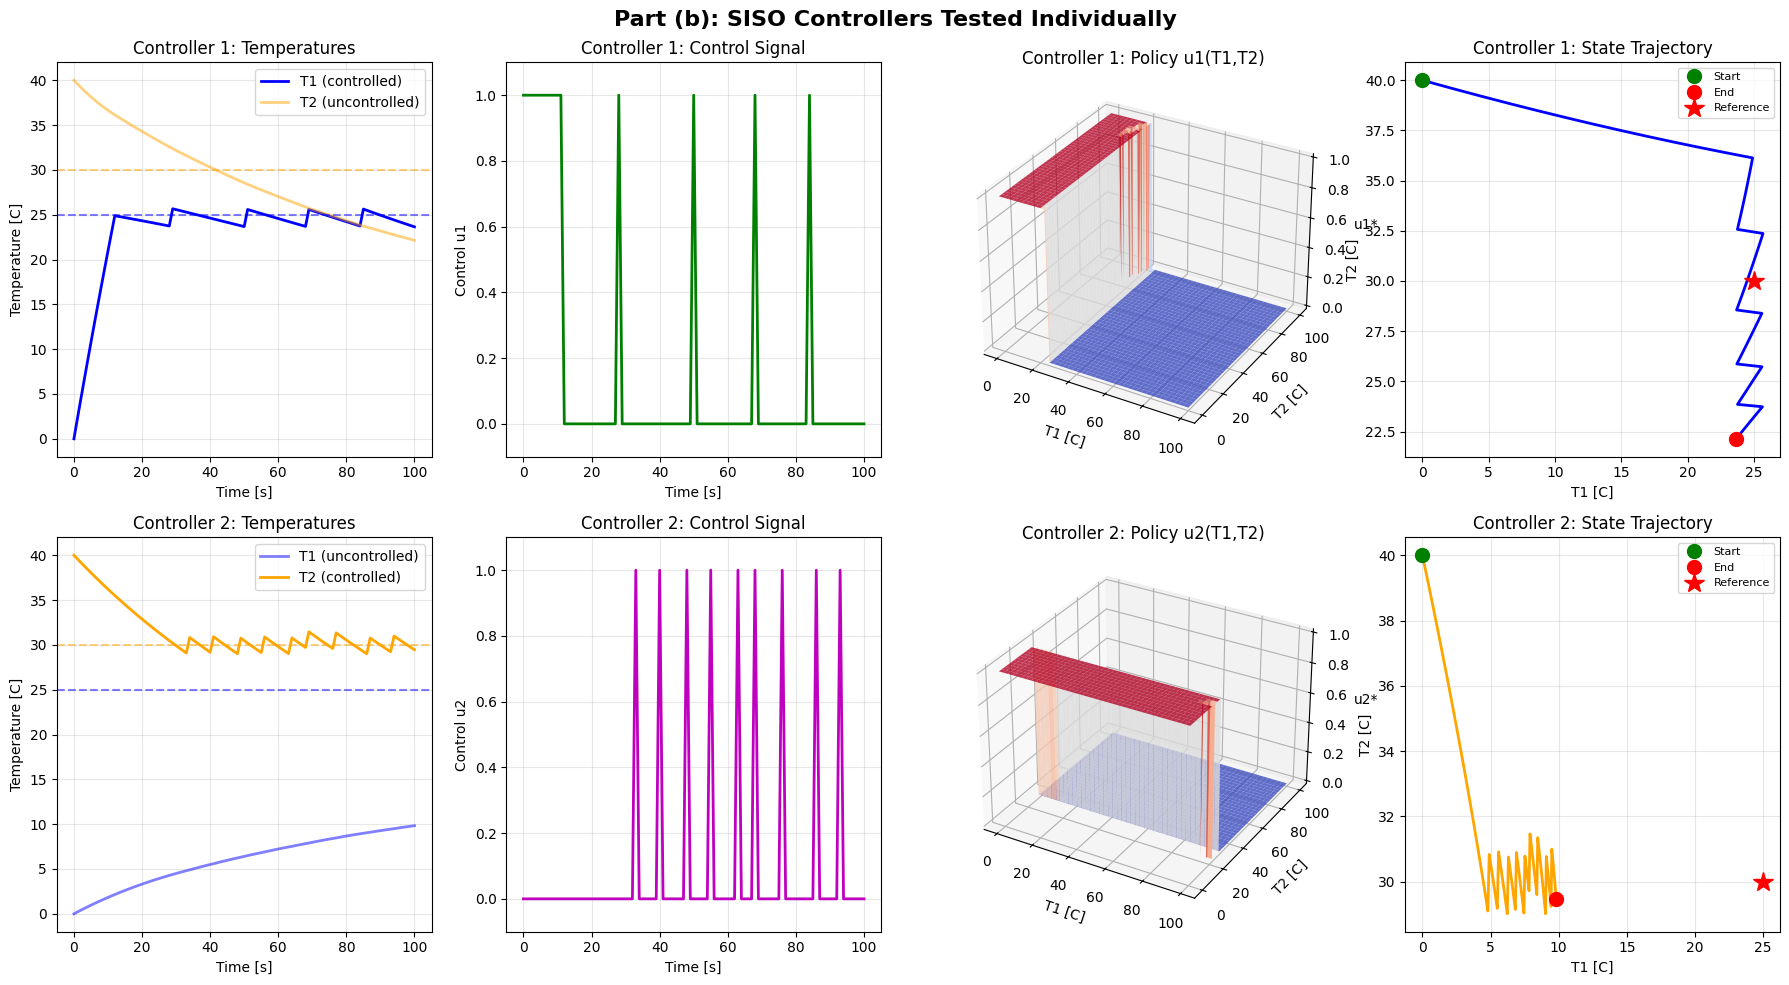

In [86]:
# Visualize SISO controllers
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Part (b): SISO Controllers Tested Individually', fontsize=16, fontweight='bold')

# Controller 1 results
ax1 = plt.subplot(2, 4, 1)
ax1.plot(T_time[:len(x_b1_only)], x_b1_only[:, 0], 'b-', linewidth=2, label='T1 (controlled)')
ax1.plot(T_time[:len(x_b1_only)], x_b1_only[:, 1], 'orange', linewidth=2, alpha=0.5, label='T2 (uncontrolled)')
ax1.axhline(y=x_ref[0], color='b', linestyle='--', alpha=0.5)
ax1.axhline(y=x_ref[1], color='orange', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [C]')
ax1.set_title('Controller 1: Temperatures')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 4, 2)
ax2.plot(T_time[:len(u1_sim_b1_only)], u1_sim_b1_only, 'g-', linewidth=2)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Control u1')
ax2.set_title('Controller 1: Control Signal')
ax2.set_ylim([-0.1, 1.1])
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 4, 3, projection='3d')
ax3.plot_surface(T1_mesh_b1, T2_mesh_b1, u1_opt_b1[:, :, 0], cmap='coolwarm', alpha=0.8)
ax3.set_xlabel('T1 [C]')
ax3.set_ylabel('T2 [C]')
ax3.set_zlabel('u1*')
ax3.set_title('Controller 1: Policy u1(T1,T2)')

ax4 = plt.subplot(2, 4, 4)
ax4.plot(x_b1_only[:, 0], x_b1_only[:, 1], 'b-', linewidth=2)
ax4.plot(x_b1_only[0, 0], x_b1_only[0, 1], 'go', markersize=10, label='Start')
ax4.plot(x_b1_only[-1, 0], x_b1_only[-1, 1], 'ro', markersize=10, label='End')
ax4.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference')
ax4.set_xlabel('T1 [C]')
ax4.set_ylabel('T2 [C]')
ax4.set_title('Controller 1: State Trajectory')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# Controller 2 results
ax5 = plt.subplot(2, 4, 5)
ax5.plot(T_time[:len(x_b2_only)], x_b2_only[:, 0], 'b-', linewidth=2, alpha=0.5, label='T1 (uncontrolled)')
ax5.plot(T_time[:len(x_b2_only)], x_b2_only[:, 1], 'orange', linewidth=2, label='T2 (controlled)')
ax5.axhline(y=x_ref[0], color='b', linestyle='--', alpha=0.5)
ax5.axhline(y=x_ref[1], color='orange', linestyle='--', alpha=0.5)
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Temperature [C]')
ax5.set_title('Controller 2: Temperatures')
ax5.legend()
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(2, 4, 6)
ax6.plot(T_time[:len(u2_sim_b2_only)], u2_sim_b2_only, 'm-', linewidth=2)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Control u2')
ax6.set_title('Controller 2: Control Signal')
ax6.set_ylim([-0.1, 1.1])
ax6.grid(True, alpha=0.3)

ax7 = plt.subplot(2, 4, 7, projection='3d')
ax7.plot_surface(T1_mesh_b2, T2_mesh_b2, u2_opt_b2[:, :, 0], cmap='coolwarm', alpha=0.8)
ax7.set_xlabel('T1 [C]')
ax7.set_ylabel('T2 [C]')
ax7.set_zlabel('u2*')
ax7.set_title('Controller 2: Policy u2(T1,T2)')

ax8 = plt.subplot(2, 4, 8)
ax8.plot(x_b2_only[:, 0], x_b2_only[:, 1], 'orange', linewidth=2)
ax8.plot(x_b2_only[0, 0], x_b2_only[0, 1], 'go', markersize=10, label='Start')
ax8.plot(x_b2_only[-1, 0], x_b2_only[-1, 1], 'ro', markersize=10, label='End')
ax8.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference')
ax8.set_xlabel('T1 [C]')
ax8.set_ylabel('T2 [C]')
ax8.set_title('Controller 2: State Trajectory')
ax8.legend(fontsize=8)
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part (c): Hybrid Automaton - Switching Between SISO Controllers

Implement the hybrid automaton (HA) to switch between the two SISO controllers using appropriate tolerance for jump guards.

**Strategy:**
- **Mode 1 (Controller 1)**: Active when Tank 1 error is larger - use SISO Controller 1 (u1, u2=0)
- **Mode 2 (Controller 2)**: Active when Tank 2 error is larger - use SISO Controller 2 (u2, u1=0)

**Guard Conditions:**
- Switch from Mode 1 to Mode 2 when: $|T_2 - T_2^{ref}| > |T_1 - T_1^{ref}| + \epsilon$
- Switch from Mode 2 to Mode 1 when: $|T_1 - T_1^{ref}| > |T_2 - T_2^{ref}| + \epsilon$

## Configuration

In [87]:
# Hybrid automaton configuration
MODE_CTRL1 = 0  # Use SISO Controller 1 (focus on Tank 1)
MODE_CTRL2 = 1  # Use SISO Controller 2 (focus on Tank 2)

mode_names_c = {
    MODE_CTRL1: "Controller 1 (Tank 1)",
    MODE_CTRL2: "Controller 2 (Tank 2)"
}

# Switching tolerance (hysteresis to prevent chattering)
epsilon_switch = 0.5  # Temperature tolerance in C

print(f"Configuration:")
print(f"Modes: 2 (SISO Controller 1, SISO Controller 2)")
print(f"Switching tolerance: {epsilon_switch}C")

Configuration:
Modes: 2 (SISO Controller 1, SISO Controller 2)
Switching tolerance: 0.5C


## Hybrid Automaton Simulation

Simulate the system with mode switching based on error magnitudes.

In [88]:
# Initialize simulation
x_c = np.zeros((N, 2))
x_c[0, :] = x0
u1_sim_c = np.zeros(N)
u2_sim_c = np.zeros(N)
mode_traj_c = np.zeros(N, dtype=int)

# Determine initial mode based on which error is larger
error_T1_init = abs(x0[0] - x_ref[0])
error_T2_init = abs(x0[1] - x_ref[1])

if error_T1_init > error_T2_init:
    current_mode = MODE_CTRL1
else:
    current_mode = MODE_CTRL2

mode_traj_c[0] = current_mode

print(f"Starting hybrid automaton simulation...")
print(f"Initial errors: T1={error_T1_init:.2f}C, T2={error_T2_init:.2f}C")
print(f"Starting in mode: {mode_names_c[current_mode]}")

for k in range(N-1):
    # Check bounds - using GLOBAL CONFIG
    if not (x_c[k, 0] >= T_MIN and x_c[k, 0] <= T_MAX and
            x_c[k, 1] >= T_MIN and x_c[k, 1] <= T_MAX):
        print(f"Warning: Stopped at k={k}/{N}: state out of bounds")
        x_c = x_c[:k+1, :]
        u1_sim_c = u1_sim_c[:k+1]
        u2_sim_c = u2_sim_c[:k+1]
        mode_traj_c = mode_traj_c[:k+1]
        break
    
    # Get current errors
    error_T1 = abs(x_c[k, 0] - x_ref[0])
    error_T2 = abs(x_c[k, 1] - x_ref[1])
    
    # Check for mode switching (with hysteresis)
    if current_mode == MODE_CTRL1:
        # Switch to Controller 2 if Tank 2 error is significantly larger
        if error_T2 > error_T1 + epsilon_switch:
            current_mode = MODE_CTRL2
    else:  # current_mode == MODE_CTRL2
        # Switch to Controller 1 if Tank 1 error is significantly larger
        if error_T1 > error_T2 + epsilon_switch:
            current_mode = MODE_CTRL1
    
    mode_traj_c[k] = current_mode
    
    # Apply control based on current mode
    j_T1 = lookup(T1_grid_b1, x_c[k, 0])[0]  # Both grids are the same
    i_T2 = lookup(T2_grid_b1, x_c[k, 1])[0]
    
    if current_mode == MODE_CTRL1:
        # Use SISO Controller 1
        u1_sim_c[k] = u1_opt_b1[i_T2, j_T1, k]
        u2_sim_c[k] = 0.0
    else:  # MODE_CTRL2
        # Use SISO Controller 2
        u1_sim_c[k] = 0.0
        u2_sim_c[k] = u2_opt_b2[i_T2, j_T1, k]
    
    # Propagate dynamics
    x_c[k+1, 0] = x_c[k, 0] + (-a1 * x_c[k, 0] + b1 * x_c[k, 1] + h1 * u1_sim_c[k]) * dt
    x_c[k+1, 1] = x_c[k, 1] + (b2 * x_c[k, 0] - a2 * x_c[k, 1] + h2 * u2_sim_c[k]) * dt

# Set final mode
mode_traj_c[-1] = current_mode

# Count mode switches
mode_switches_c = np.sum(mode_traj_c[1:] != mode_traj_c[:-1])

print(f"Simulation complete!")
print(f"Final state: T1={x_c[-1,0]:.2f}C, T2={x_c[-1,1]:.2f}C")
print(f"Reference:   T1={x_ref[0]}C, T2={x_ref[1]}C")
print(f"Final error: T1={x_c[-1,0]-x_ref[0]:.2f}C, T2={x_c[-1,1]-x_ref[1]:.2f}C")
print(f"Mode switches: {mode_switches_c}")

Starting hybrid automaton simulation...
Initial errors: T1=25.00C, T2=10.00C
Starting in mode: Controller 1 (Tank 1)
Simulation complete!
Final state: T1=25.41C, T2=29.64C
Reference:   T1=25.0C, T2=30.0C
Final error: T1=0.41C, T2=-0.36C
Mode switches: 14


## Performance Metrics

In [89]:
# Calculate performance metrics
ss_error_T1_c = x_c[-1, 0] - x_ref[0]
ss_error_T2_c = x_c[-1, 1] - x_ref[1]

# Calculate total cost
total_cost_c = 0
for k in range(len(x_c)-1):
    L_k = Q1_a * (x_c[k, 0] - x_ref[0])**2 + Q2_a * (x_c[k, 1] - x_ref[1])**2 + \
          R1_a * u1_sim_c[k]**2 + R2_a * u2_sim_c[k]**2
    total_cost_c += L_k * dt

L_N = Q1_a * (x_c[-1, 0] - x_ref[0])**2 + Q2_a * (x_c[-1, 1] - x_ref[1])**2
total_cost_c += L_N

# Mode statistics
time_in_mode1 = np.sum(mode_traj_c == MODE_CTRL1) * dt
time_in_mode2 = np.sum(mode_traj_c == MODE_CTRL2) * dt
percent_mode1 = 100 * np.sum(mode_traj_c == MODE_CTRL1) / len(mode_traj_c)
percent_mode2 = 100 * np.sum(mode_traj_c == MODE_CTRL2) / len(mode_traj_c)

print("\n" + "="*60)
print("PERFORMANCE METRICS - HYBRID AUTOMATON")
print("="*60)
print(f"Steady-state error Tank 1: {ss_error_T1_c:.4f} C")
print(f"Steady-state error Tank 2: {ss_error_T2_c:.4f} C")
print(f"Total accumulated cost:    {total_cost_c:.2f}")
print(f"\nMode switching:")
print(f"  Number of switches: {mode_switches_c}")
print(f"  Time in Controller 1 (Tank 1): {time_in_mode1:.1f}s ({percent_mode1:.1f}%)")
print(f"  Time in Controller 2 (Tank 2): {time_in_mode2:.1f}s ({percent_mode2:.1f}%)")
print(f"\nControl effort:")
print(f"  u1: mean={np.mean(u1_sim_c):.4f}, max={np.max(u1_sim_c):.4f}")
print(f"  u2: mean={np.mean(u2_sim_c):.4f}, max={np.max(u2_sim_c):.4f}")
print("="*60)


PERFORMANCE METRICS - HYBRID AUTOMATON
Steady-state error Tank 1: 0.4101 C
Steady-state error Tank 2: -0.3620 C
Total accumulated cost:    42989.86

Mode switching:
  Number of switches: 14
  Time in Controller 1 (Tank 1): 39.0s (38.6%)
  Time in Controller 2 (Tank 2): 62.0s (61.4%)

Control effort:
  u1: mean=0.1584, max=1.0000
  u2: mean=0.0495, max=1.0000


## Visualization

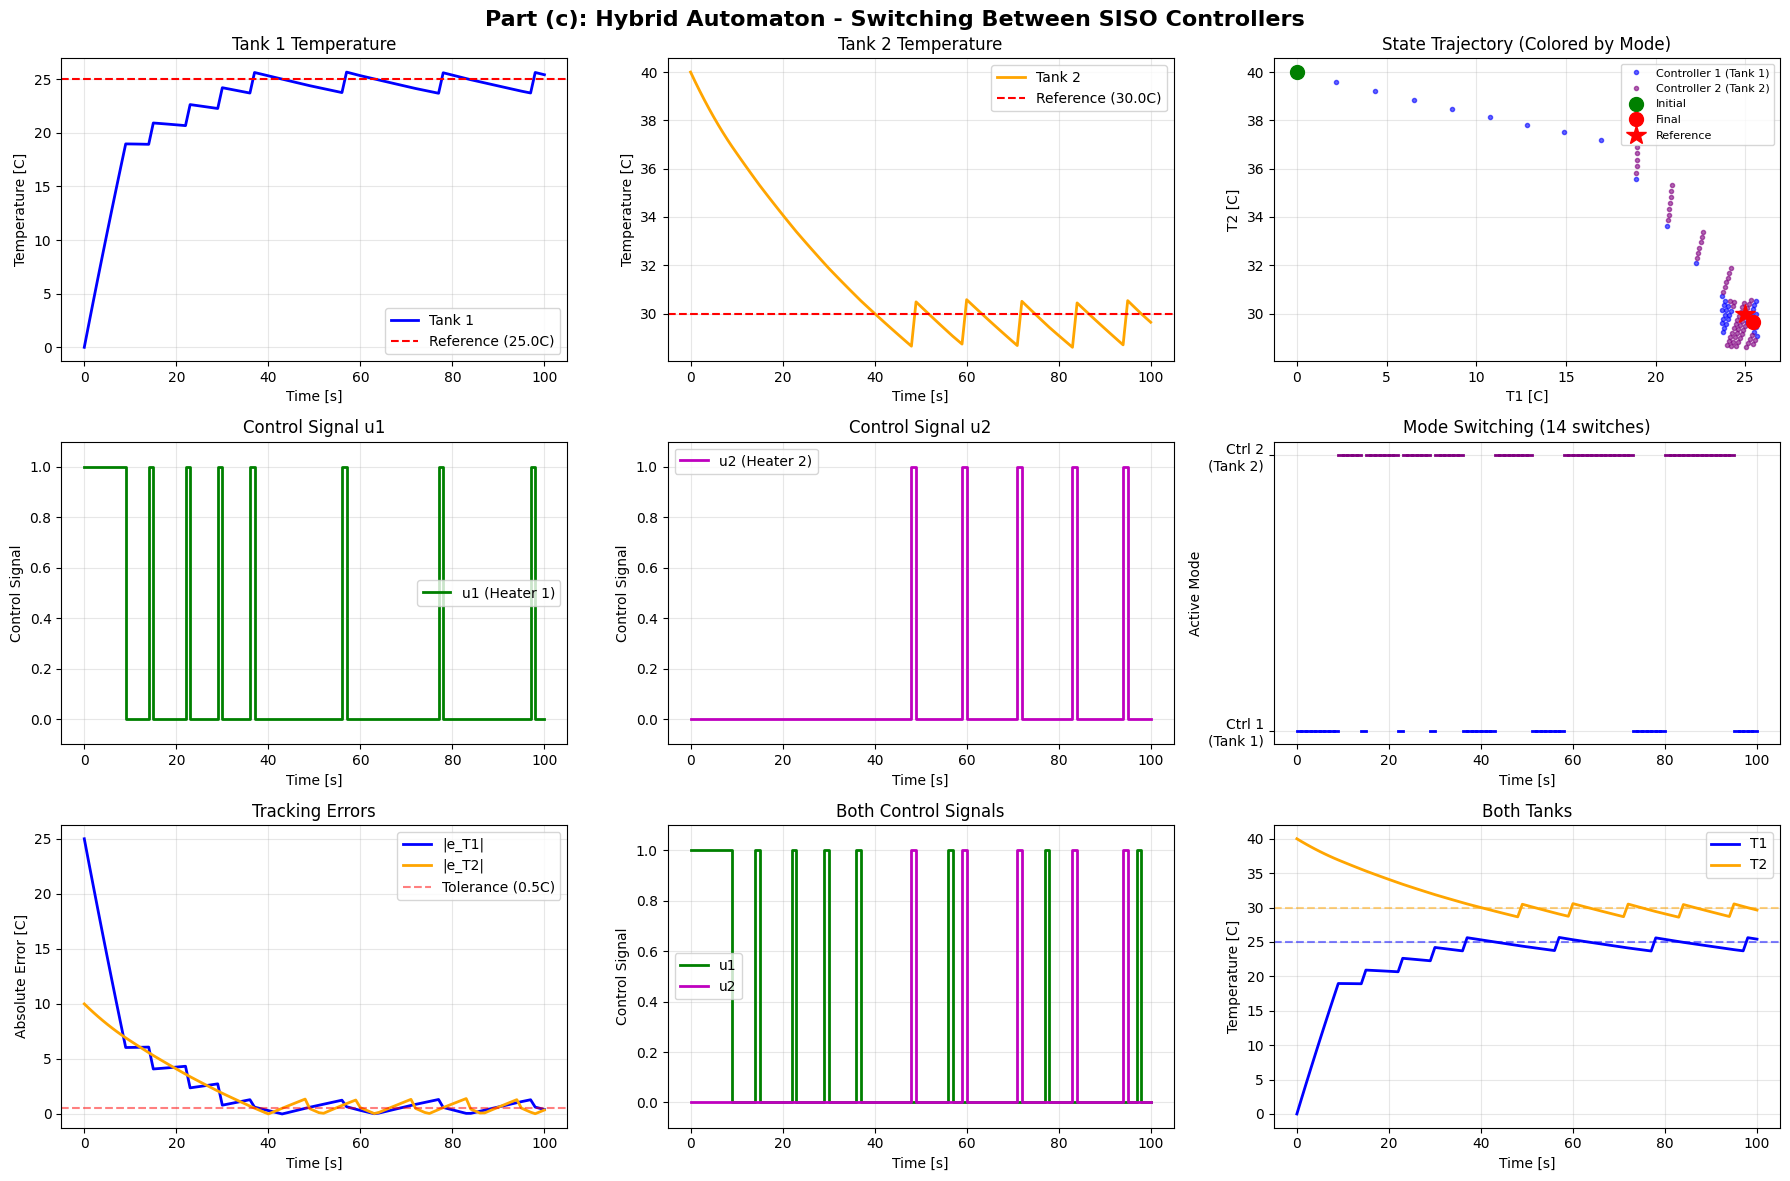

In [90]:
# Visualize hybrid automaton results
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Part (c): Hybrid Automaton - Switching Between SISO Controllers', fontsize=16, fontweight='bold')

# Temperature trajectories
ax1 = plt.subplot(3, 3, 1)
ax1.plot(T_time[:len(x_c)], x_c[:, 0], 'b-', linewidth=2, label='Tank 1')
ax1.axhline(y=x_ref[0], color='red', linestyle='--', label=f'Reference ({x_ref[0]}C)')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [C]')
ax1.set_title('Tank 1 Temperature')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 2)
ax2.plot(T_time[:len(x_c)], x_c[:, 1], 'orange', linewidth=2, label='Tank 2')
ax2.axhline(y=x_ref[1], color='red', linestyle='--', label=f'Reference ({x_ref[1]}C)')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Temperature [C]')
ax2.set_title('Tank 2 Temperature')
ax2.legend()
ax2.grid(True, alpha=0.3)

# State space trajectory colored by mode
ax3 = plt.subplot(3, 3, 3)
for mode in [MODE_CTRL1, MODE_CTRL2]:
    mask = mode_traj_c == mode
    if np.any(mask):
        color = 'blue' if mode == MODE_CTRL1 else 'purple'
        ax3.plot(x_c[mask, 0], x_c[mask, 1], 'o', color=color, 
                markersize=3, alpha=0.6, label=mode_names_c[mode])
ax3.plot(x_c[0, 0], x_c[0, 1], 'go', markersize=10, label='Initial', zorder=5)
ax3.plot(x_c[-1, 0], x_c[-1, 1], 'ro', markersize=10, label='Final', zorder=5)
ax3.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference', zorder=5)
ax3.set_xlabel('T1 [C]')
ax3.set_ylabel('T2 [C]')
ax3.set_title('State Trajectory (Colored by Mode)')
ax3.legend(fontsize=8, loc='best')
ax3.grid(True, alpha=0.3)

# Control signals
ax4 = plt.subplot(3, 3, 4)
ax4.step(T_time[:len(u1_sim_c)], u1_sim_c, 'g-', linewidth=2, where='post', label='u1 (Heater 1)')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Control Signal')
ax4.set_title('Control Signal u1')
ax4.set_ylim([-0.1, 1.1])
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
ax5.step(T_time[:len(u2_sim_c)], u2_sim_c, 'm-', linewidth=2, where='post', label='u2 (Heater 2)')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Control Signal')
ax5.set_title('Control Signal u2')
ax5.set_ylim([-0.1, 1.1])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Mode trajectory
ax6 = plt.subplot(3, 3, 6)
colors_mode = ['blue', 'purple']
for i in range(len(mode_traj_c)-1):
    ax6.plot([T_time[i], T_time[i+1]], [mode_traj_c[i], mode_traj_c[i]], 
            color=colors_mode[mode_traj_c[i]], linewidth=2)
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Active Mode')
ax6.set_yticks([0, 1])
ax6.set_yticklabels(['Ctrl 1\n(Tank 1)', 'Ctrl 2\n(Tank 2)'])
ax6.set_title(f'Mode Switching ({mode_switches_c} switches)')
ax6.grid(True, alpha=0.3)

# Error trajectories
ax7 = plt.subplot(3, 3, 7)
error_T1_traj = np.abs(x_c[:, 0] - x_ref[0])
error_T2_traj = np.abs(x_c[:, 1] - x_ref[1])
ax7.plot(T_time[:len(x_c)], error_T1_traj, 'b-', linewidth=2, label='|e_T1|')
ax7.plot(T_time[:len(x_c)], error_T2_traj, 'orange', linewidth=2, label='|e_T2|')
ax7.axhline(y=epsilon_switch, color='red', linestyle='--', alpha=0.5, label=f'Tolerance ({epsilon_switch}C)')
ax7.set_xlabel('Time [s]')
ax7.set_ylabel('Absolute Error [C]')
ax7.set_title('Tracking Errors')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Both controls together
ax8 = plt.subplot(3, 3, 8)
ax8.step(T_time[:len(u1_sim_c)], u1_sim_c, 'g-', linewidth=2, where='post', label='u1')
ax8.step(T_time[:len(u2_sim_c)], u2_sim_c, 'm-', linewidth=2, where='post', label='u2')
ax8.set_xlabel('Time [s]')
ax8.set_ylabel('Control Signal')
ax8.set_title('Both Control Signals')
ax8.set_ylim([-0.1, 1.1])
ax8.legend()
ax8.grid(True, alpha=0.3)

# Both temperatures together
ax9 = plt.subplot(3, 3, 9)
ax9.plot(T_time[:len(x_c)], x_c[:, 0], 'b-', linewidth=2, label='T1')
ax9.plot(T_time[:len(x_c)], x_c[:, 1], 'orange', linewidth=2, label='T2')
ax9.axhline(y=x_ref[0], color='b', linestyle='--', alpha=0.5)
ax9.axhline(y=x_ref[1], color='orange', linestyle='--', alpha=0.5)
ax9.set_xlabel('Time [s]')
ax9.set_ylabel('Temperature [C]')
ax9.set_title('Both Tanks')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Comparison:

Compare the performance of all three approaches.

In [91]:
print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)
print(f"{'':>30} {'MIMO DDP':<20} {'Hybrid SISO':<20}")
print("-"*80)
print(f"{'Final T1 error [C]':<30} {ss_error_T1_a:>19.4f} {ss_error_T1_c:>19.4f}")
print(f"{'Final T2 error [C]':<30} {ss_error_T2_a:>19.4f} {ss_error_T2_c:>19.4f}")
print(f"{'Total cost':<30} {total_cost_a:>19.2f} {total_cost_c:>19.2f}")
print(f"{'Avg u1':<30} {np.mean(u1_sim_a):>19.4f} {np.mean(u1_sim_c):>19.4f}")
print(f"{'Avg u2':<30} {np.mean(u2_sim_a):>19.4f} {np.mean(u2_sim_c):>19.4f}")
print(f"{'Mode switches':<30} {'N/A':>19} {mode_switches_c:>19}")
print("="*80)
print(f"  Controller 1 (Tank 1 only): Final T1={x_b1_only[-1,0]:.2f}C, T2={x_b1_only[-1,1]:.2f}C")
print(f"  Controller 2 (Tank 2 only): Final T1={x_b2_only[-1,0]:.2f}C, T2={x_b2_only[-1,1]:.2f}C")
print("="*80)


SUMMARY COMPARISON
                               MIMO DDP             Hybrid SISO         
--------------------------------------------------------------------------------
Final T1 error [C]                          0.5467              0.4101
Final T2 error [C]                         -0.4090             -0.3620
Total cost                                46351.21            42989.86
Avg u1                                      0.1584              0.1584
Avg u2                                      0.0495              0.0495
Mode switches                                  N/A                  14
  Controller 1 (Tank 1 only): Final T1=23.65C, T2=22.14C
  Controller 2 (Tank 2 only): Final T1=9.83C, T2=29.46C


## Final Comparison Visualization

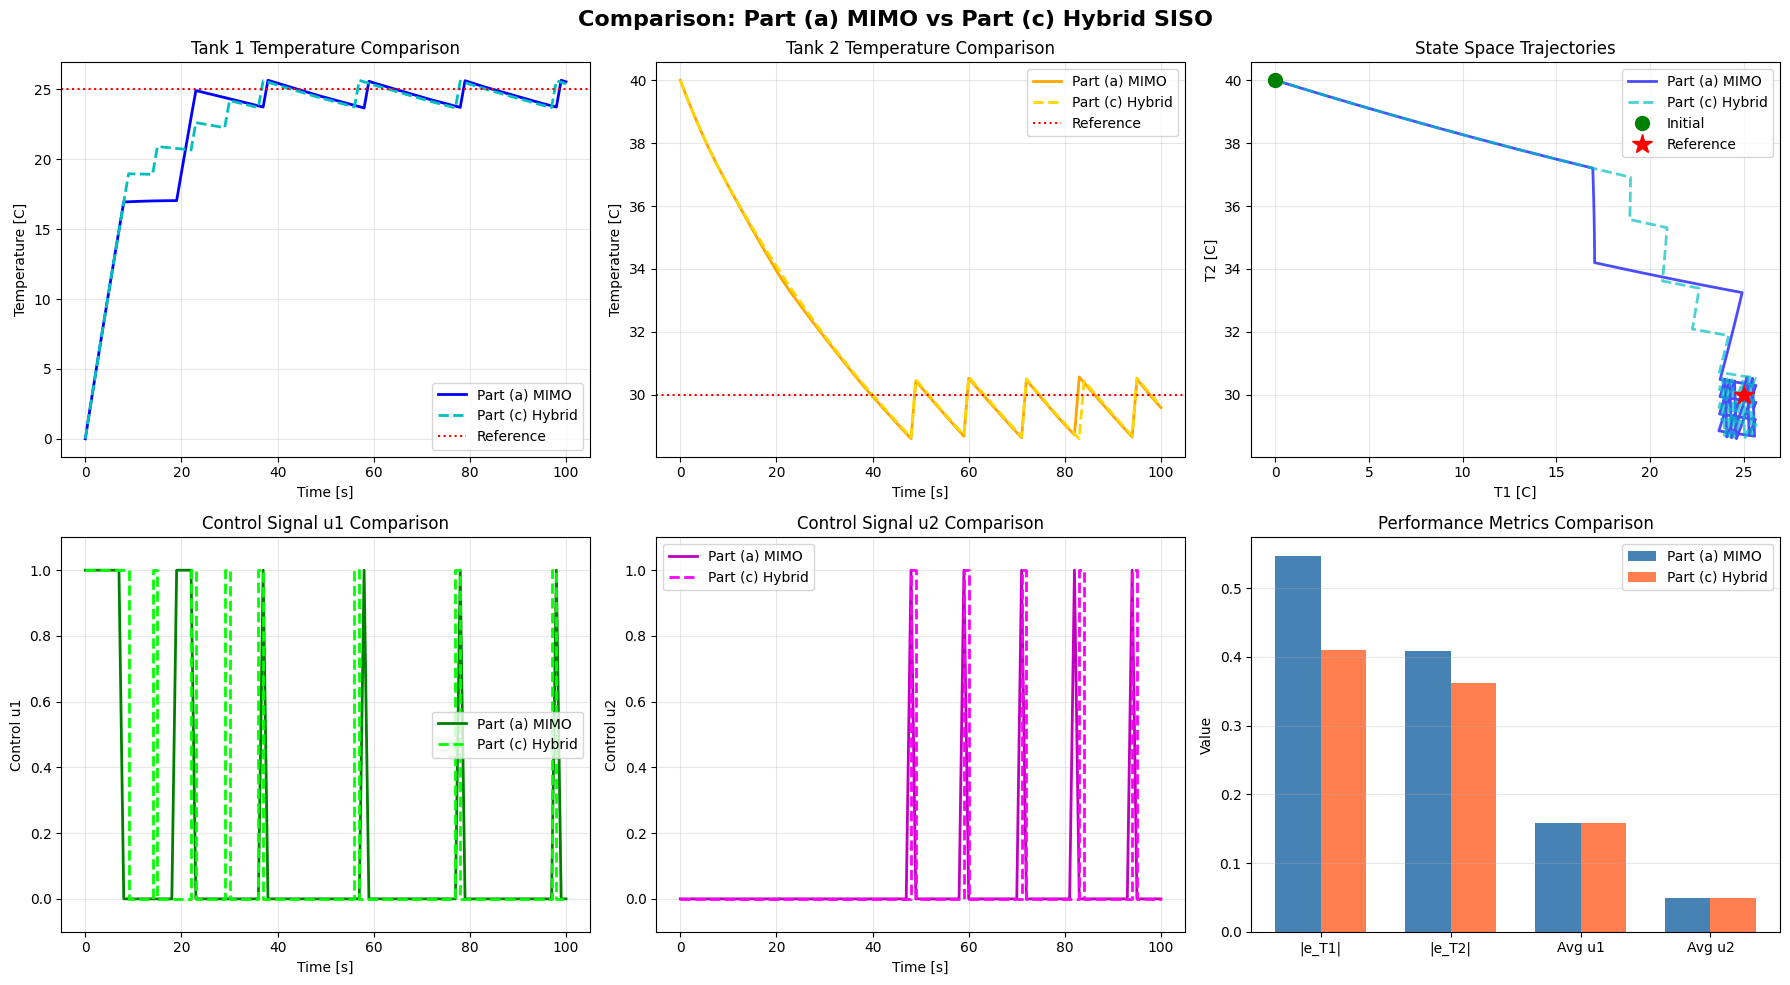

In [92]:
# Create side-by-side comparison
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Comparison: Part (a) MIMO vs Part (c) Hybrid SISO', fontsize=16, fontweight='bold')

# Temperature comparisons
ax1 = plt.subplot(2, 3, 1)
ax1.plot(T_time[:len(x_a)], x_a[:, 0], 'b-', linewidth=2, label='Part (a) MIMO')
ax1.plot(T_time[:len(x_c)], x_c[:, 0], 'c--', linewidth=2, label='Part (c) Hybrid')
ax1.axhline(y=x_ref[0], color='red', linestyle=':', label='Reference')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [C]')
ax1.set_title('Tank 1 Temperature Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
ax2.plot(T_time[:len(x_a)], x_a[:, 1], 'orange', linewidth=2, label='Part (a) MIMO')
ax2.plot(T_time[:len(x_c)], x_c[:, 1], 'gold', linestyle='--', linewidth=2, label='Part (c) Hybrid')
ax2.axhline(y=x_ref[1], color='red', linestyle=':', label='Reference')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Temperature [C]')
ax2.set_title('Tank 2 Temperature Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# State trajectories
ax3 = plt.subplot(2, 3, 3)
ax3.plot(x_a[:, 0], x_a[:, 1], 'b-', linewidth=2, alpha=0.7, label='Part (a) MIMO')
ax3.plot(x_c[:, 0], x_c[:, 1], 'c--', linewidth=2, alpha=0.7, label='Part (c) Hybrid')
ax3.plot(x0[0], x0[1], 'go', markersize=10, label='Initial')
ax3.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Reference')
ax3.set_xlabel('T1 [C]')
ax3.set_ylabel('T2 [C]')
ax3.set_title('State Space Trajectories')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Control comparisons
ax4 = plt.subplot(2, 3, 4)
ax4.plot(T_time[:len(u1_sim_a)], u1_sim_a, 'g-', linewidth=2, label='Part (a) MIMO')
ax4.step(T_time[:len(u1_sim_c)], u1_sim_c, 'lime', linestyle='--', linewidth=2, where='post', label='Part (c) Hybrid')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Control u1')
ax4.set_title('Control Signal u1 Comparison')
ax4.set_ylim([-0.1, 1.1])
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(2, 3, 5)
ax5.plot(T_time[:len(u2_sim_a)], u2_sim_a, 'm-', linewidth=2, label='Part (a) MIMO')
ax5.step(T_time[:len(u2_sim_c)], u2_sim_c, 'magenta', linestyle='--', linewidth=2, where='post', label='Part (c) Hybrid')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Control u2')
ax5.set_title('Control Signal u2 Comparison')
ax5.set_ylim([-0.1, 1.1])
ax5.legend()
ax5.grid(True, alpha=0.3)

# Performance metrics bar chart
ax6 = plt.subplot(2, 3, 6)
metrics = ['|e_T1|', '|e_T2|', 'Avg u1', 'Avg u2']
part_a_vals = [abs(ss_error_T1_a), abs(ss_error_T2_a), np.mean(u1_sim_a), np.mean(u2_sim_a)]
part_c_vals = [abs(ss_error_T1_c), abs(ss_error_T2_c), np.mean(u1_sim_c), np.mean(u2_sim_c)]

x_pos = np.arange(len(metrics))
width = 0.35

ax6.bar(x_pos - width/2, part_a_vals, width, label='Part (a) MIMO', color='steelblue')
ax6.bar(x_pos + width/2, part_c_vals, width, label='Part (c) Hybrid', color='coral')
ax6.set_ylabel('Value')
ax6.set_title('Performance Metrics Comparison')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(metrics)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()